In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Step 1 : Imports & metrics

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
import os


In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
import numpy as np


Step 2: Model Definition
Implements a U-Net style encoder–decoder with skip connections for image-to-image enhancement.

Encoder: repeated conv blocks + maxpool.

Bottleneck: deepest conv block.

Decoder: transposed conv upsampling + conv blocks; concatenates skip connections.

Final output: sigmoid to constrain outputs to [0,1], suitable for normalized grayscale images.

Inputs / outputs

Input: tensor shape [B, 1, H, W] (grayscale).

Output: tensor same spatial size [B, 1, H, W] with values in [0,1].

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256, 512]):
        super(UNet, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()

        # Encoder
        for feature in features:
            self.downs.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, feature, kernel_size=3, padding=1),
                    nn.BatchNorm2d(feature),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(feature, feature, kernel_size=3, padding=1),
                    nn.BatchNorm2d(feature),
                    nn.ReLU(inplace=True)
                )
            )
            in_channels = feature
            self.downs.append(nn.MaxPool2d(kernel_size=2, stride=2))

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features[-1], features[-1]*2, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(features[-1]*2, features[-1]*2, 3, padding=1),
            nn.ReLU(inplace=True)
        )

        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(
                nn.Sequential(
                    nn.Conv2d(feature*2, feature, 3, padding=1),
                    nn.BatchNorm2d(feature),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(feature, feature, 3, padding=1),
                    nn.BatchNorm2d(feature),
                    nn.ReLU(inplace=True)
                )
            )

        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        for i in range(0, len(self.downs), 2):
            x = self.downs[i](x)
            skip_connections.append(x)
            x = self.downs[i+1](x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for i in range(0, len(self.ups), 2):
            x = self.ups[i](x)
            skip_connection = skip_connections[i//2]
            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:])
            x = torch.cat((skip_connection, x), dim=1)
            x = self.ups[i+1](x)

        return torch.sigmoid(self.final_conv(x))


Step 3 : MRIDataset custom Dataset
Loads grayscale MRI images from a directory, applies transforms, and returns (input, target) pairs.

Uses self-supervised self-reconstruction where input == target (useful for denoising / enhancement training).

Inputs / outputs

Input: image_dir path and transform.

Output: each __getitem__ returns a tuple (image_tensor, image_tensor)

In [ ]:
class MRIDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        image = Image.open(img_path).convert("L")  # grayscale
        if self.transform:
            image = self.transform(image)
        return image, image  # input = output for enhancement


Step 4 : Transforms, dataset, dataloader, model init, training loop
Defines preprocessing (resize + to tensor).

Creates dataset + DataLoader for batching.

Instantiates the U-Net on CUDA, Adam optimizer, and MSE loss for pixel-wise reconstruction.

Training loop: for each batch, forward → compute MSE → backprop → update weights.

Prints last batch loss per epoch.

Inputs / outputs

Inputs: images from path; hyperparameters (batch size, lr, epochs).

Outputs: trained model in memory (weights updated).

In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

dataset = MRIDataset("/content/drive/MyDrive/brain_mri/image_dataset", transform=transform)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

model = UNet().to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

for epoch in range(10):
    for img, target in loader:
        img, target = img.cuda(), target.cuda()
        output = model(img)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")


Epoch 1: Loss = 0.0281
Epoch 2: Loss = 0.0088
Epoch 3: Loss = 0.0064
Epoch 4: Loss = 0.0026
Epoch 5: Loss = 0.0126
Epoch 6: Loss = 0.0037
Epoch 7: Loss = 0.0020
Epoch 8: Loss = 0.0065
Epoch 9: Loss = 0.0062
Epoch 10: Loss = 0.0021


Step 5 : Enhancement & metrics script (apply model to dataset)
Loads dataset CSV with image_path entries.

For every image, reads and resizes it, converts to tensor, runs the model (in eval() mode), and converts enhanced output back to an image.

Computes PSNR and SSIM comparing original (resized) to enhanced output.

Saves enhanced images and appends the enhanced path + metrics into the CSV.

Inputs / outputs

Input: brain_tumor_info.csv with image_path column, trained model.

Output: enhanced images on disk and updated CSV brain_tumor_info_metrics.csv with enhanced_image_path, PSNR, SSIM

In [ ]:

device = "cuda" if torch.cuda.is_available() else "cpu"
model.eval()

csv_path = "/content/drive/MyDrive/brain_mri/brain_tumor_info.csv"
df = pd.read_csv(csv_path)

save_dir = "/content/drive/MyDrive/brain_mri/enhanced_images"
os.makedirs(save_dir, exist_ok=True)

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

def enhance_image(model, img_path, save_dir, device="cuda"):
    try:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"⚠️ Skipped (not found): {img_path}")
            return None, None, None

        img_resized = cv2.resize(img, (256, 256))
        img_tensor = torch.tensor(img_resized / 255.0, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

        with torch.no_grad():
            enhanced_tensor = model(img_tensor)

        enhanced = enhanced_tensor.squeeze().cpu().numpy()
        enhanced = np.clip(enhanced, 0, 1)

        psnr_val = psnr(img_resized / 255.0, enhanced, data_range=1.0)
        ssim_val = ssim(img_resized / 255.0, enhanced, data_range=1.0)

        filename = os.path.basename(img_path)
        enhanced_path = os.path.join(save_dir, f"enhanced_{filename}")
        cv2.imwrite(enhanced_path, (enhanced * 255).astype(np.uint8))

        return enhanced_path, psnr_val, ssim_val

    except Exception as e:
        print(f"⚠️ Error processing {img_path}: {e}")
        return None, None, None

enhanced_paths = []
psnr_list = []
ssim_list = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    img_path = row["image_path"]

    enhanced_path, psnr_val, ssim_val = enhance_image(model, img_path, save_dir, device)

    enhanced_paths.append(enhanced_path)
    psnr_list.append(psnr_val)
    ssim_list.append(ssim_val)

df["enhanced_image_path"] = enhanced_paths
df["PSNR"] = psnr_list
df["SSIM"] = ssim_list

output_csv_path = "/content/drive/MyDrive/brain_mri/brain_tumor_info_metrics.csv"
df.to_csv(output_csv_path, index=False)

print(f"✅ All images enhanced and metrics saved to: {output_csv_path}")


100%|██████████| 396/396 [03:49<00:00,  1.73it/s]

✅ All images enhanced and metrics saved to: /content/drive/MyDrive/brain_mri/brain_tumor_info_metrics.csv


Step 6 : Visualization: plot original vs enhanced
Picks 3 random samples with enhanced images and displays original and enhanced side-by-side with PSNR/SSIM annotations.

Inputs / outputs

Input: the updated dataframe df with enhanced_image_path, PSNR, and SSIM.

Output: matplotlib figure with 3 pairs of images.

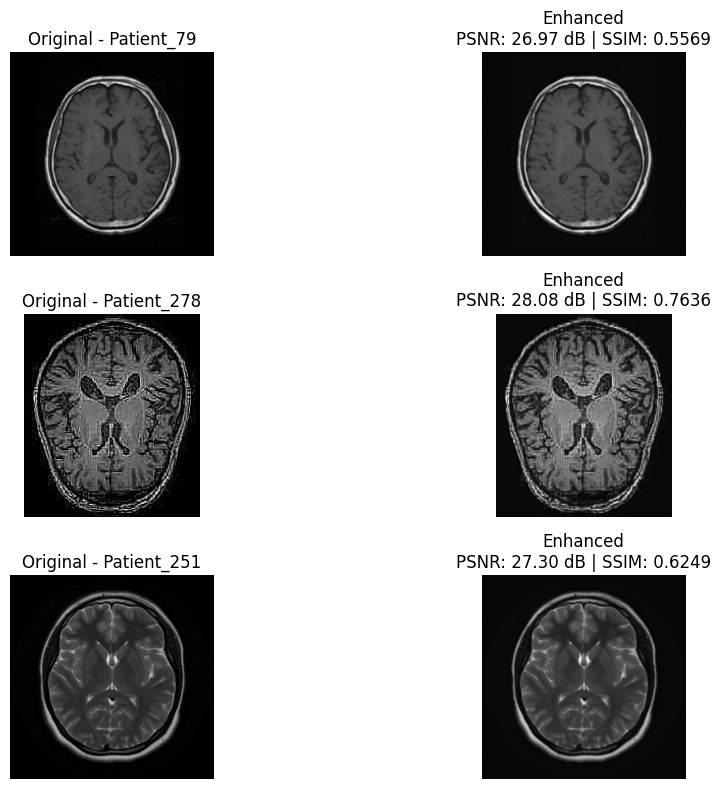

In [ ]:
sample_df = df.dropna(subset=["enhanced_image_path"]).sample(3, random_state=42)

plt.figure(figsize=(12, 8))

for i, (_, row) in enumerate(sample_df.iterrows()):
    original = cv2.imread(row["image_path"], cv2.IMREAD_GRAYSCALE)
    enhanced = cv2.imread(row["enhanced_image_path"], cv2.IMREAD_GRAYSCALE)

    if original.shape != enhanced.shape:
        enhanced = cv2.resize(enhanced, (original.shape[1], original.shape[0]))

    psnr_val = row["PSNR"]
    ssim_val = row["SSIM"]

    plt.subplot(3, 2, 2*i + 1)
    plt.imshow(original, cmap='gray')
    plt.title(f"Original - {row['patient_id']}")
    plt.axis('off')

    plt.subplot(3, 2, 2*i + 2)
    plt.imshow(enhanced, cmap='gray')
    plt.title(f"Enhanced\nPSNR: {psnr_val:.2f} dB | SSIM: {ssim_val:.4f}")
    plt.axis('off')

plt.tight_layout()
plt.show()
